# Compare transpiler settings
*Usage estimate: under 1 minute on IBM Nazca (NOTE: This is an estimate only. Your runtime may vary.)*

## Background

To ensure faster and more efficient results, as of 1 March 2024, circuits and observables need to be transformed to only use instructions supported by the QPU (quantum processing unit) before being submitted to the Qiskit Runtime primitives. We call these *instruction set architecture* (ISA) circuits and observables. One common way to do this is to use the transpiler's `generate_preset_pass_manager` function.  However, you might choose to follow a more manual process.

For example, you might want to target a specific subset of qubits on a specific device. This tutorial tests the performance of different transpiler settings by completing the full process of creating, transpiling, and submitting circuits.

## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.2 or later, with visualization support (`pip install 'qiskit[visualization]'`)
* Qiskit Runtime 0.28 or later (`pip install qiskit-ibm-runtime`)

## Setup

In [ ]:
# Create circuit to test transpiler on
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import GroverOperator, Diagonal

# Use Statevector object to calculate the ideal output
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.transpiler import PassManager

from qiskit.circuit.library import XGate
from qiskit.quantum_info import hellinger_fidelity

# Qiskit Runtime
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Batch,
    SamplerV2 as Sampler,
)
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

## Step 1: Map classical inputs to a quantum problem

Create a small circuit for the transpiler to try to optimize. This example creates a circuit that carries out Grover's algorithm with an oracle that marks the state `111`. Next, simulate the ideal distribution (what you'd expect to measure if you ran this on a perfect quantum computer an infinite number of times) for comparison later.

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=127
)
backend.name

'ibm_kyoto'

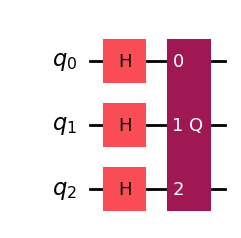

In [29]:
oracle = Diagonal([1] * 7 + [-1])
qc = QuantumCircuit(3)
qc.h([0, 1, 2])
qc = qc.compose(GroverOperator(oracle))

qc.draw(output="mpl", style="iqp")

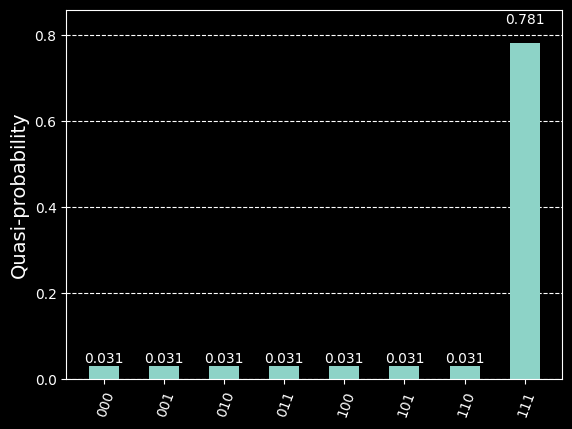

In [30]:
ideal_distribution = Statevector.from_instruction(qc).probabilities_dict()

plot_histogram(ideal_distribution)

## Step 2: Optimize problem for quantum hardware execution

Next, transpile the circuits for the QPU. You will compare the performance of the transpiler with `optimization_level` set to `0` (lowest) against `3` (highest). The lowest optimization level does the bare minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much smarter and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results.

The following cell transpiles `qc` for both values of `optimization_level`, prints the number of two-qubit gates, and adds the transpiled circuits to a list. Some of the transpiler's algorithms are randomized, so it sets a seed for reproducibility.

In [31]:
# Need to add measurements to the circuit
qc.measure_all()

# Find the correct two-qubit gate
twoQ_gates = set(["ecr", "cz", "cx"])
for gate in backend.basis_gates:
    if gate in twoQ_gates:
        twoQ_gate = gate

circuits = []
for optimization_level in [0, 3]:
    pm = generate_preset_pass_manager(
        optimization_level, backend=backend, seed_transpiler=0
    )
    t_qc = pm.run(qc)
    print(
        f"Two-qubit gates (optimization_level={optimization_level}): ",
        t_qc.count_ops()[twoQ_gate],
    )
    circuits.append(t_qc)

Two-qubit gates (optimization_level=0):  21
Two-qubit gates (optimization_level=3):  14


Since CNOTs usually have a high error rate, the circuit transpiled with `optimization_level=3` should perform much better.

Another way you can improve performance is through [dynamic decoupling](/api/qiskit/qiskit.transpiler.passes.PadDynamicalDecoupling), by applying a sequence of gates to idling qubits. This cancels out some unwanted interactions with the environment. The following cell adds dynamic decoupling to the circuit transpiled with `optimization_level=3` and adds it to the list.

In [ ]:
# Get gate durations so the transpiler knows how long each operation takes
durations = backend.target.durations()

# This is the sequence we'll apply to idling qubits
dd_sequence = [XGate(), XGate()]

# Run scheduling and dynamic decoupling passes on circuit
pm = PassManager(
    [
        ASAPScheduleAnalysis(durations),
        PadDynamicalDecoupling(durations, dd_sequence),
    ]
)
circ_dd = pm.run(circuits[1])

# Add this new circuit to our list
circuits.append(circ_dd)

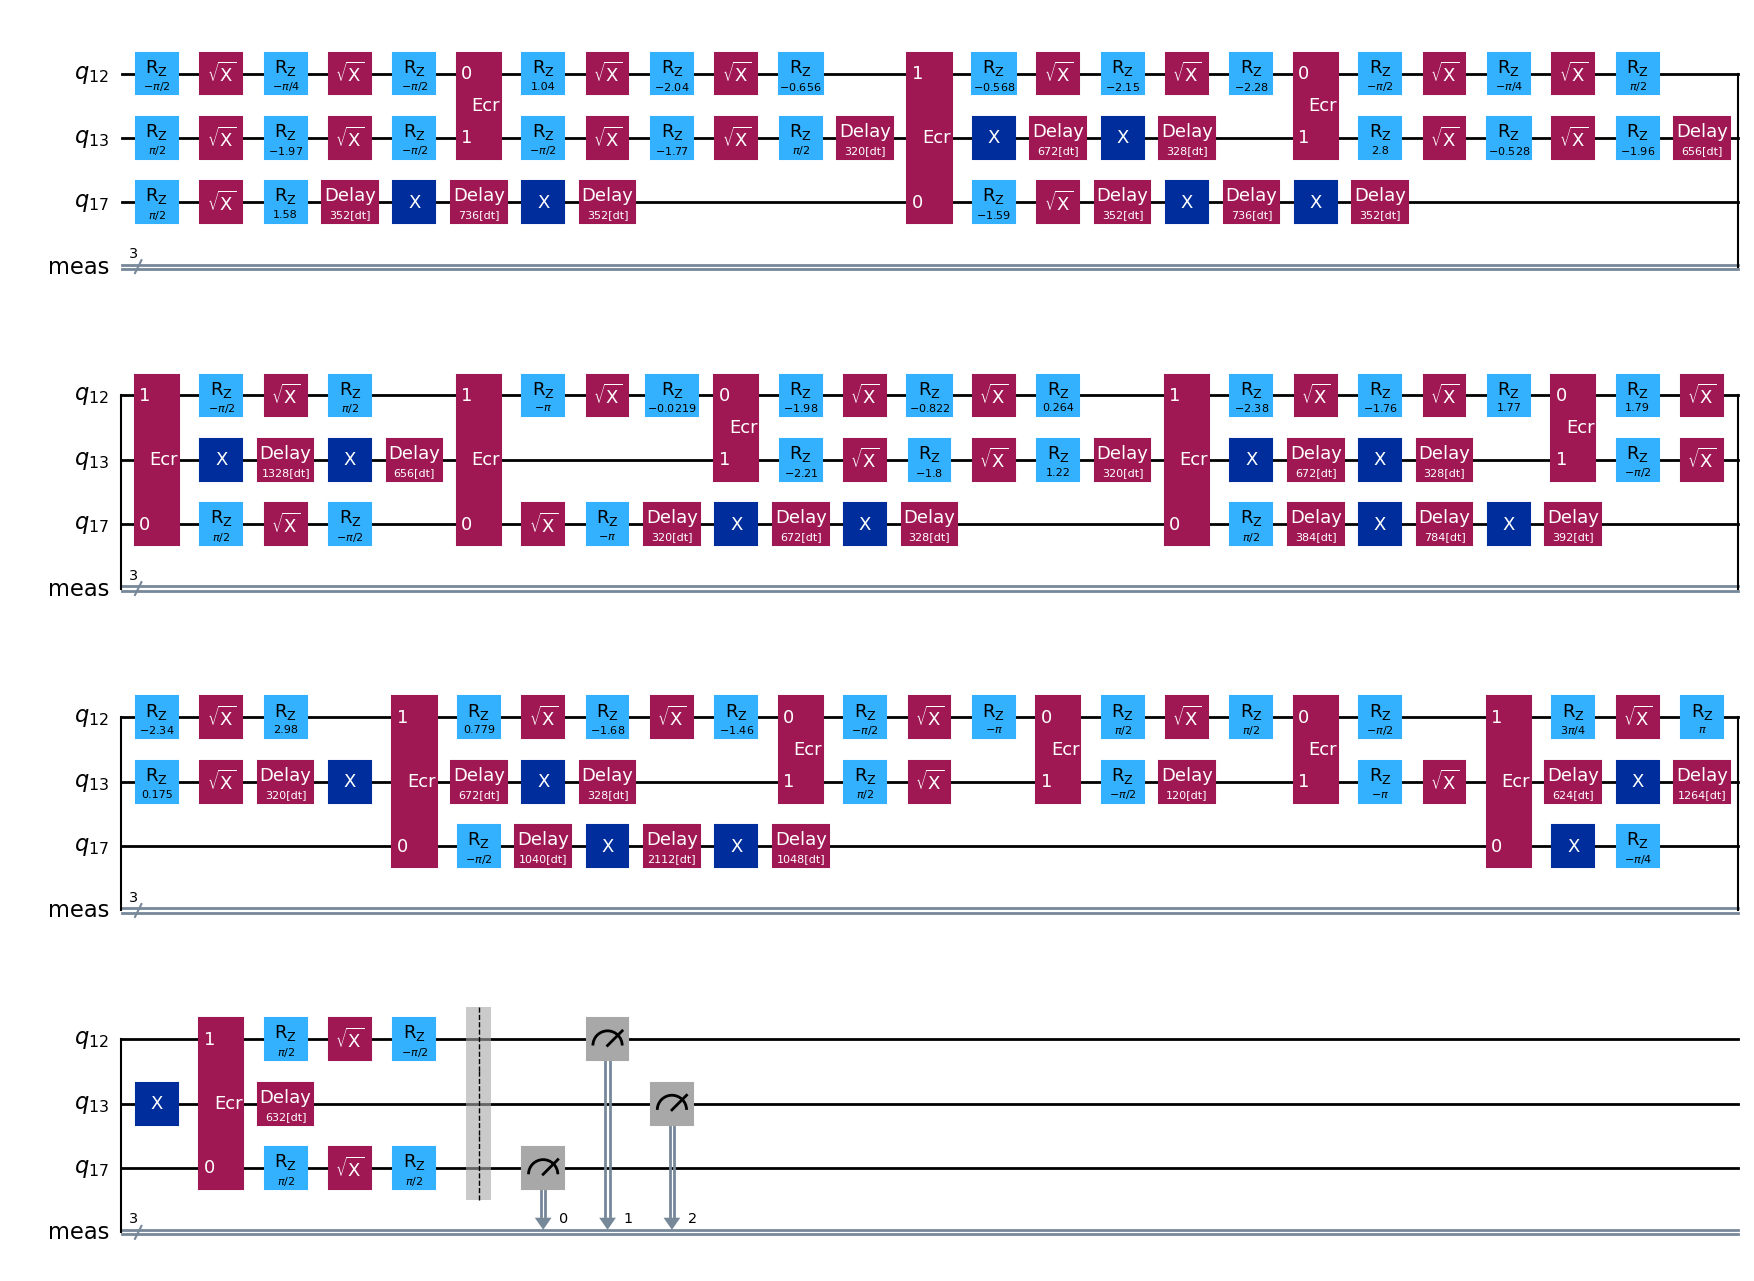

In [33]:
circ_dd.draw(output="mpl", style="iqp", idle_wires=False)

## Step 3: Execute using Qiskit primitives

At this point, you have a list of circuits transpiled for the specified QPU. Next, create an instance of the sampler primitive and start a batched job using the context manager (`with ...:`), which automatically opens and closes the batch.

Within the context manager, sample the circuits and store the results to `result`.

In [34]:
with Batch(backend=backend):
    sampler = Sampler()
    job = sampler.run(
        [(circuit) for circuit in circuits],  # sample all three circuits
        shots=8000,
    )
    result = job.result()

## Step 4: Post-process and return result in desired classical format

Finally, plot the results from the device runs against the ideal distribution. You can see the results with `optimization_level=3` are closer to the ideal distribution due to the lower gate count, and `optimization_level=3 + dd` is even closer due to the dynamic decoupling.

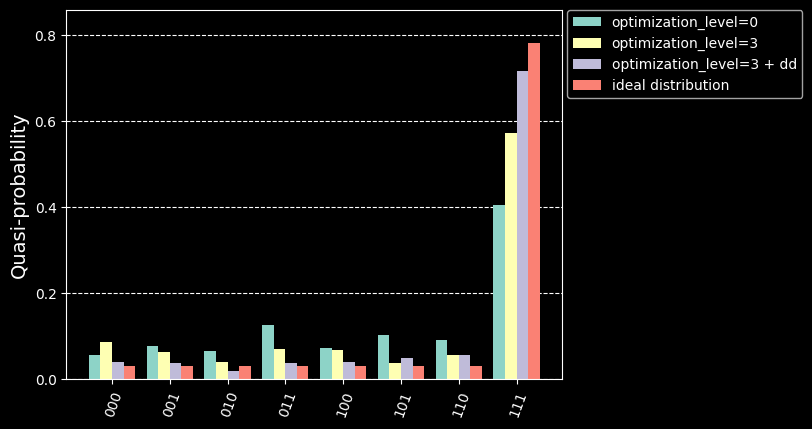

In [35]:
binary_prob = [
    {
        k: v / res.data.meas.num_shots
        for k, v in res.data.meas.get_counts().items()
    }
    for res in result
]
plot_histogram(
    binary_prob + [ideal_distribution],
    bar_labels=False,
    legend=[
        "optimization_level=0",
        "optimization_level=3",
        "optimization_level=3 + dd",
        "ideal distribution",
    ],
)

You can confirm this by computing the [Hellinger fidelity](/api/qiskit/quantum_info) between each set of results and the ideal distribution (higher is better, and 1 is perfect fidelity).

In [ ]:
for prob in binary_prob:
    print(f"{hellinger_fidelity(prob, ideal_distribution):.3f}")

0.848
0.945
0.990


## Tutorial survey

Please take one minute to provide feedback on this tutorial. Your insights will help us improve our content offerings and user experience.

[Link to survey](https://your.feedback.ibm.com/jfe/form/SV_0j1SlLPkooyeFJY)

© IBM Corp. 2024